In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
pd.set_option('display.max_columns', None)

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
### Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

from ancIBD.ibd_stats.funcs import new_columns

compute-e-16-233.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 28


In [2]:
def load_ibd(out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/",
             file="av2.tsv", skip_rows=False):
    df = pd.read_csv(out_folder + file, sep="\t")
    if skip_rows:
        df = df[::2]
    return df

def plot_scatter_ibd(ax =0, df_ibds=[], min_cm=12, s=40,
                     c="deepskyblue", m="o", label="", fs=12, 
                     xlim=[-5,3600], ylim=[0,55], savepath="", show=False, 
                     ec="gray", c_col="",  n_std=0):
    """Plot Scatter Plot of IBD.
    c_col: if given plot color stated in column c_col of df_ibds
    n_std: radius of confidence ellipse. if >0: plot"""
    
    if len(c_col)>0:
        c = df_ibds[c_col].values
        
    if ax==0:
        plt.figure(figsize=(8,8))
        ax = plt.gca()
    
    ### Do the actual Plot
    x, y = df_ibds[f"sum_IBD>{min_cm}"], df_ibds[f"n_IBD>{min_cm}"]
    fig = ax.scatter(x, y, s=s,
               ec=ec, linewidth=0.5, color=c, marker=m, label=label)
    
    ### CI Ellipse
    if n_std>0:
        confidence_ellipse(x, y, ax, edgecolor=c, n_std=n_std)

    ax.set_xlabel(f"Sum IBD >{min_cm}cM [cM]", fontsize=fs)
    ax.set_ylabel(f"# IBD >{min_cm}cM [Count]", fontsize=fs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
    else:
        return fig
    
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data
    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.
    n_std : float
    The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    Returns matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def apply_roh_correction(df, df_roh, cm_tot = 3400):
    """Apply ROH correction to df, based on ROH values in df_roh.
    Return new dataframe with additional columns"""
    dft = df.copy().reset_index(drop=True)
    
    dft = pd.merge(dft, df_roh[["iid", "sum_roh>12"]], left_on="iid1", right_on="iid", how="left")
    dft = pd.merge(dft, df_roh[["iid", "sum_roh>12"]], left_on="iid2", right_on="iid", how="left")
    
    c_fac1 = ((cm_tot - dft["sum_roh>12_x"]) / cm_tot).fillna(1)
    c_fac2 = ((cm_tot - dft["sum_roh>12_y"]) / cm_tot).fillna(1)

    dft["IIMR_iid1_c"] =  dft["IIMR_iid1"] / c_fac1
    dft["IIMR_iid2_c"] =  dft["IIMR_iid2"] / c_fac2

    pmr_avg = dft["IIMR_iid1_c"] + dft["IIMR_iid2_c"]
    dft["r_c"] =  (pmr_avg - dft["PMR"]) / pmr_avg * 2
    return dft

In [3]:
### Load Pedsim
files_gp = ["gp1.f.tsv", "gp2.f.tsv", "gp3.f.tsv"]
files_av = ["av1.f.tsv", "av2.f.tsv", "av3.f.tsv", "av4.f.tsv", "av5.f.tsv"]
files_sibs = ["sib.f.tsv", "hsib.f.tsv"]
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

df_gps = [load_ibd(file=f, out_folder=out_folder,
                   skip_rows=True) for f in files_gp]

df_avs = [load_ibd(file=f, out_folder=out_folder) for f in files_av]
df_sibs = load_ibd(file=files_sibs[0], out_folder=out_folder)
df_hsibs = load_ibd(file=files_sibs[1], out_folder=out_folder)

df_par = load_ibd(file="parent.f.tsv", out_folder=out_folder)[1:2]

### 1) Various Single Plots

In [6]:
df_ibds = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.all.v1.tsv", 
                      sep="\t") # compression='gzip'

len(df_ibds)

146117

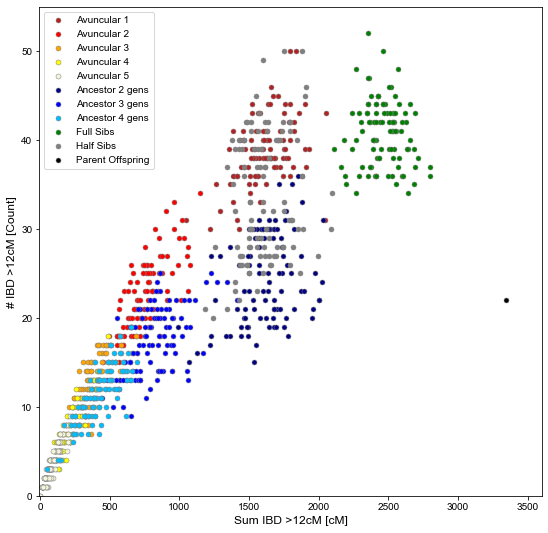

In [7]:
plt.figure(figsize=(9,9))

ax = plt.gca()

plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=25)

plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2 gens", 
                 c="navy", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3 gens", 
                 c="blue", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4 gens", 
                 c="deepskyblue", s=25)

plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
                 c="gray", s=25)
plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=25)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)

ax.legend(loc="upper left")
plt.savefig("./figs/pedsim/simulated_pedsim.png", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

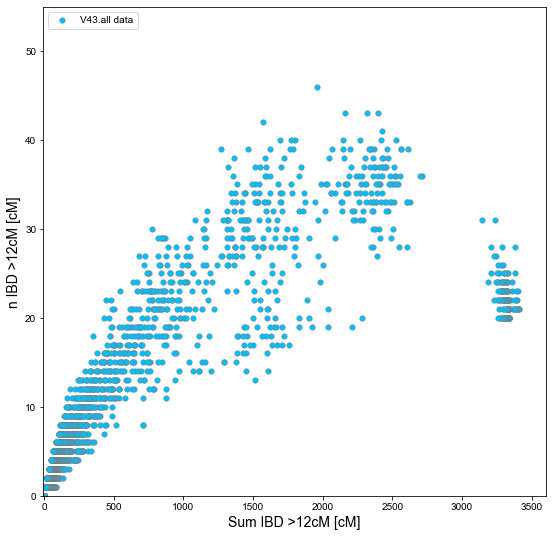

In [6]:
plt.figure(figsize=(9,9))

ax = plt.gca()
plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.legend(loc="upper left")

plt.savefig("./figs/pedsim/v43.all.png", bbox_inches ='tight', pad_inches = 0, dpi=400)

plt.show()

In [4]:
print("test")

test


### 2) Plot ancIBD European run versus PED_SIM [main figure paper]
Standalone from here

In [72]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v54.1b.tsv", sep="\t") #v54.1b is version with >0.7 maxGP
df_ibds = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v54.1c.tsv", sep="\t") # v54.1c is 1000G version
print(f"Loaded {len(df_ibds)} IBD segments")
print(f"IBD data between {len(df_meta)} IIDs")

### Load Pedsim
files_gp = ["gp1.f.tsv", "gp2.f.tsv", "gp3.f.tsv"]
files_av = ["av1.f.tsv", "av2.f.tsv", "av3.f.tsv", "av4.f.tsv", "av5.f.tsv"]
files_sibs = ["sib.f.tsv", "hsib.f.tsv"]
out_folder = "/n/groups/reich/hringbauer/git/hapBLOCK/output/pedsim/"

df_gps = [load_ibd(file=f, out_folder=out_folder,
                   skip_rows=True) for f in files_gp]

df_avs = [load_ibd(file=f, out_folder=out_folder) for f in files_av]
df_sibs = load_ibd(file=files_sibs[0], out_folder=out_folder)
df_hsibs = load_ibd(file=files_sibs[1], out_folder=out_folder)

df_par = load_ibd(file="parent.f.tsv", out_folder=out_folder)[1:2]

Loaded 562966 IBD segments
IBD data between 11404 IIDs


In [6]:
df_par

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20
1,par100_g2-b1-i1,par100_g3-b1-i1,261.713366,3174.06214,20.0,3174.06214,20.0,3174.06214,20.0,3174.06214,20.0


Saved to ./figs/scatter/ibd.v54.1d.png


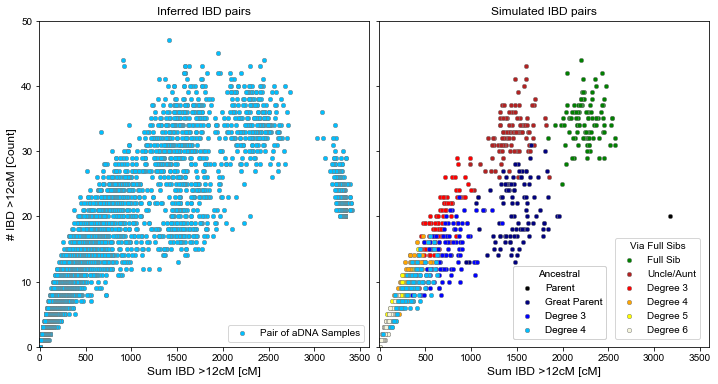

In [11]:
ylim = [0,50]
savepath = "./figs/scatter/ibd.v54.1d.png" #v53.1

fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

fs=12
s=20
f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=s)

m_anc = "o"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=s, m=m_anc)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="navy", s=s, m=m_anc)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="blue", s=s, m=m_anc)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="deepskyblue", s=s, m=m_anc)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

### Do the real data
plot_scatter_ibd(ax=ax1, df_ibds=df_ibds, show=False, label=f"Pair of aDNA Samples", s=s)
ax1.legend(loc="lower right")
ax1.set_ylim(ylim) #[0,50] in original


### Titles
ax.set_title("Simulated IBD pairs", fontsize=fs)
ax1.set_title("Inferred IBD pairs", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

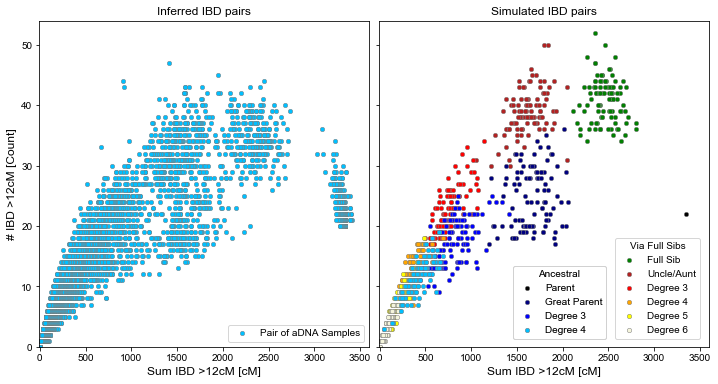

In [27]:
ylim = [0,54]
#savepath = "./figs/scatter/ibd.v54.1c.png" #v53.1
savepath = ""


fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)

ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

fs=12
s=20
f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=s)

m_anc = "o"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=s, m=m_anc)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="navy", s=s, m=m_anc)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="blue", s=s, m=m_anc)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="deepskyblue", s=s, m=m_anc)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

### Do the real data
plot_scatter_ibd(ax=ax1, df_ibds=df_ibds, show=False, label=f"Pair of aDNA Samples", s=s)
ax1.legend(loc="lower right")
ax1.set_ylim(ylim) #[0,50] in original


### Titles
ax.set_title("Simulated IBD pairs", fontsize=fs)
ax1.set_title("Inferred IBD pairs", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

### Optional [1x run]: Combine the simulated output to single tsv file

In [11]:
df_sibs["relationship"] = "Full Sib"
df_avs[0]["relationship"] = "Uncle/Aunt"
df_avs[1]["relationship"] = "Via Full Sib Deg. 3"
df_avs[2]["relationship"] = "Via Full Sib Deg. 4"
df_avs[3]["relationship"] = "Via Full Sib Deg. 5"
df_avs[4]["relationship"] = "Via Full Sib Deg. 6"
df_par["relationship"] = "Parent"
df_gps[0]["relationship"] = "Great Parent"
df_gps[1]["relationship"] = "Ancestral Deg. 3"
df_gps[2]["relationship"] = "Ancestral Deg. 4"
df_all = pd.concat([df_sibs, pd.concat(df_avs), df_par, pd.concat(df_gps)])

In [17]:
savepath="./output/pedsim/pedsim_table_allpairs.tsv"
df_all.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(df_all)} PEDSIM pairs to: {savepath}")

Saved 901 PEDSIM pairs to: ./output/pedsim/pedsim_table_allpairs.tsv


In [ ]:
[df["relationship"] = for df in df_avs]

# 3) Explore Inigos PMR data

In [4]:
%%time
### Load PMR table
df = pd.read_csv("/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ind.v54.1c_IO.tsv", 
                 sep="\t", low_memory=False)
df = df.drop(columns="Unnamed: 11")
idx = df["sum_IBD>12"]==0
idx.loc[idx.idxmax()] = False # Keep one 0 row

df = df[~idx]
print(f"Filtered to {len(df)}/{len(idx)} pairs with IBD>12cm")

### Add Meta Info
path_meta = f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v54.1b.tsv"
df_meta = pd.read_csv(path_meta, sep="\t")
#new_columns(df, df_meta, col = ["age", "clst", "study", "loc", "n_cov_snp", "frac_gp"]) #"clst"
new_columns(df, df_meta, col = ["study", "age"]) #"clst"

### Add ROH Info
df_roh = pd.read_csv("/n/groups/reich/hringbauer/hapsburg_runs/output/combined_roh05.v56.1.tsv", sep="\t")
dct_rep = {"tem003_wNonUDG.SG":"tem003_noUDG.SG", "tem002_wNonUDG.SG":"tem002_noUDG.SG",
           "yak024_wNonUDG.SG":"yak024_noUDG.SG", "yak022_wNonUDG.SG":"yak022_noUDG.SG"}
df_roh.replace({"iid":dct_rep}, inplace=True)

df = apply_roh_correction(df, df_roh)

### Define relevant columns
rel_col = "Relatedness coefficient r (autosomes)" # Define Name of Relatedness column
rel_colc = "r_c"

Filtered to 103639/562966 pairs with IBD>12cm
CPU times: user 1.47 s, sys: 418 ms, total: 1.89 s
Wall time: 2.32 s


# 3a) Optional Filtering
Based on browsing initial list - filtering out faulty indivdiuals and papers

In [8]:
study_fail = ["MarotiTorokCurrBio2022"]
idx = df["study1"].isin(study_fail) | df["study2"].isin(study_fail)

iid_fail = ["I21393","I21387","I21387","I21395","I12438", 
            "DRU015.A_noUDG", "DRU018.A_noUDG", "DAV-A-9_38_noUDG.SG", "DAV-A-8_38_noUDG.SG", 
            "irk034_wNonUDG.SG","I33704_d"]
idx2 = df["iid1"].isin(iid_fail) | df["iid2"].isin(iid_fail)

print(f"Based on study: {np.sum(idx)}/{len(idx)}")
print(f"Based on iid: {np.sum(idx2)}/{len(idx)}")

df = df[~idx & ~idx2].copy()

### Filter duplicates
idx = df["r_c"]>0.75
df = df[~idx].copy()
print(f"Filtered {np.sum(idx)} duplicate IIDs")

Based on study: 964/103639
Based on iid: 154/103639
Filtered 142 duplicate IIDs


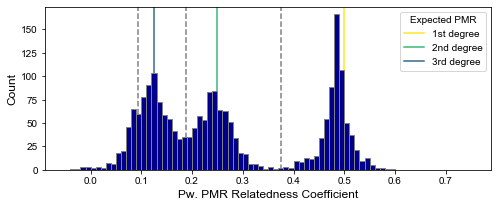

In [40]:
plt.figure(figsize=(8,3))
ax = plt.gca()
c_fac = 1
#ax.axvline(0.75*c_fac, zorder=0, c="gray")
ax.axvline(0.375*c_fac, zorder=0, c="gray", ls="--")
ax.axvline(0.1875*c_fac, zorder=0, c="gray", ls="--")
ax.axvline(0.09375*c_fac, zorder=0, c="gray", ls="--") #0.09375 0.065

ax.axvline(0.5, zorder=0, c="#fde725", label="1st degree")
ax.axvline(0.25, zorder=0, c="#35b779", label="2nd degree")
ax.axvline(0.125, zorder=0, c="#31688e", label="3rd degree")
ax.legend(title="Expected PMR", loc="upper right")

ax.hist(df[rel_col], ec="gray", color="darkblue",
        bins = np.linspace(-0.05,0.75, 81))

fs_l=12
ax.set_xlabel("Pw. PMR Relatedness Coefficient", fontsize=fs_l)
ax.set_ylabel("Count", fontsize=fs_l)

plt.savefig("./figs/scatter/pmr_histogram.pdf", bbox_inches ='tight', pad_inches = 0, dpi=400)

plt.show()

In [43]:
np.sum(~df["r_c"].isnull())

2089

### Add color-code to pw. table

In [44]:
cutoffs = [0.09375, 0.18375, 0.375, 0.75]
colors = ["#fde725", "#35b779", "#31688e", "#440154"]

df["color_pmr"] = "white"
idx = df["n_IBD>20"]>=3
 
df.loc[idx, "color_pmr"] = "maroon"
    
for c,col in zip(cutoffs,colors):
          idx = df[rel_colc] >=  c
          print(f'>{c}: n={np.sum(idx)}')
          df.loc[idx, "color_pmr"] = col

>0.09375: n=1935
>0.18375: n=1322
>0.375: n=656
>0.75: n=0


In [ ]:
df = df.sort_values(by="r_c", ascending=False) # How to sort for plot
df

In [187]:
df = df.sort_values(by="sum_IBD>20") # How to sort for plot

### Do the big Scatter Plot

Saved to ./figs/scatter/ibd.v54.1e.png


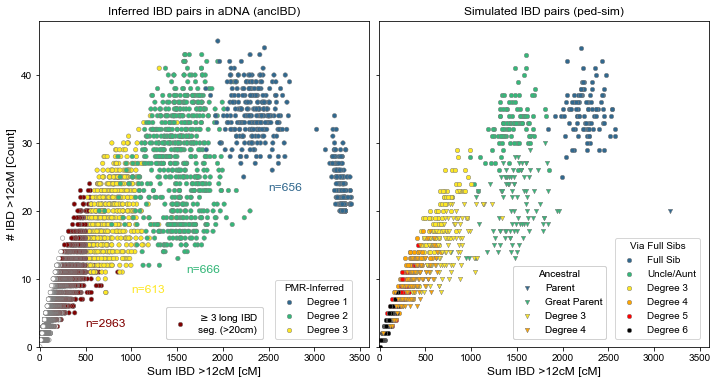

In [50]:
ylim = [0,48]
savepath = "./figs/scatter/ibd.v54.1e.png" #./figs/scatter/ibd.v54.1d.png
fs=12
s=20

fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.03)
ax1 = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

f1= plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="#31688e", s=s)
f2 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="#35b779", s=s)
f3 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="#fde725", s=s)
f4 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=s)
f5 =plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="red", s=s)
f6 = plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="black", s=s)

m_anc = "v"
ec="gray"
a1 = plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="#31688e", s=s, m=m_anc, ec=ec)
a2 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2", 
                 c="#35b779", s=s, m=m_anc, ec=ec)
a3 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3", 
                 c="#fde725", s=s, m=m_anc, ec=ec)
a4 = plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4", 
                 c="orange", s=s, m=m_anc, ec=ec)

plots = [f1, f2, f3, f4, f5, f6]
lbls = ["Full Sib", "Uncle/Aunt", "Degree 3", "Degree 4", "Degree 5", "Degree 6"]
leg = ax.legend(plots, lbls, fontsize=10, 
                bbox_to_anchor=(0.7, 0.01),
          loc="lower left", title=f"Via Full Sibs")
ax.add_artist(leg)

plots1 = [a1, a2, a3, a4]
lbls1 = ["Parent", "Great Parent", "Degree 3", "Degree 4"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax.legend(plots1, lbls1, fontsize=10, 
                bbox_to_anchor=(0.39, 0.01),
          loc="lower left", title=f"Ancestral")
ax.add_artist(leg1)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)
ax.set_ylabel("")
ax.set_ylim(ylim)
ax.set_yticklabels([])

###################################
### Empirical data


plot_scatter_ibd(ax=ax1, df_ibds=df, show=False, 
                 label=f"Pair of aDNA Samples", s=s, c_col="color_pmr")
n = plot_scatter_ibd(ax=ax1, df_ibds=df[:0], show=False, label=">=3 IBD>20cm", 
                     c="maroon", s=s, m="o", ec=ec)
ax1.set_ylim(ylim) #[0,50] in original

#### Legends
plots1 = [f1, f2, f3]
lbls1 = ["Degree 1", "Degree 2", "Degree 3"]
#assert(n==len(df_p)) # Sanity Check
leg1 = ax1.legend(plots1, lbls1, fontsize=10, 
                 bbox_to_anchor=(0.7, 0.01),
                 loc="lower left", title=f"PMR-Inferred")
ax1.add_artist(leg1)

leg2 = ax1.legend([n], [f"$\geq$3 long IBD\nseg. (>20cm)"], fontsize=10, 
                bbox_to_anchor=(0.37, 0.01),
                loc="lower left", title=f"")
ax1.add_artist(leg2)

### Titles
ax.set_title("Simulated IBD pairs (ped-sim)", fontsize=fs)
ax1.set_title("Inferred IBD pairs in aDNA (ancIBD)", fontsize=fs)

### Text
ax1.text(500, 3, "n=2963", fontsize=fs, color="maroon", backgroundcolor="white")
ax1.text(1000, 8, "n=613", fontsize=fs, color="#fde725", backgroundcolor="white")
ax1.text(1600, 11, "n=666", fontsize=fs, color="#35b779", backgroundcolor="white")
ax1.text(2500, 23, "n=656", fontsize=fs, color="#31688e", backgroundcolor="white")

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
plt.show()

In [45]:
df["color_pmr"].value_counts()

white      97481
maroon      2963
#35b779      666
#31688e      656
#fde725      613
Name: color_pmr, dtype: int64

## 3c) Browse problematic samples

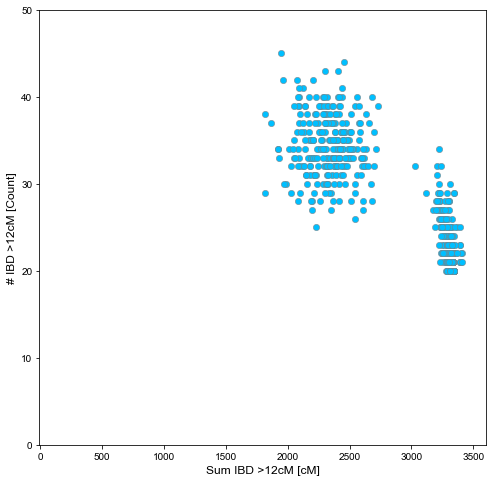

In [48]:
#["#fde725", "#35b779", "#31688e", "#440154"]
dft = df[df["color_pmr"] == "#31688e"] #.sort_values(by="")
plot_scatter_ibd(df_ibds=dft, ylim=[0, 50])

In [ ]:
dft[:20]

In [22]:
df_roh[df_roh["iid"].str.contains("I33803")]

,max_roh,iid,pop,sum_roh>4,n_roh>4,sum_roh>8,n_roh>8,sum_roh>12,n_roh>12,sum_roh>20,n_roh>20,Master ID,loc,lat,lon,age,age_range,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,family,sex,contact,data_type


In [55]:
I21393 # three first degree IBD with high n
I21387 # two first degree IBD with high n
I21387 # two first degree IBD with low sum
I21395 	I12438 # Fowler et al, addback versions used
MS-43.SG 	MS-45.SG # Taroki first degree shennenigans
SZRV-67.SG|SZRV-212.SG # Taroki first degree shennenigans. first degree with low sum
DRU015.A_noUDG 	DRU018.A_noUDG # Joscha IDB - crayz high intra-indivdiual PMR? (>0.150661)


### Check inbreeding values (that reduce the baseline- PMR - making indivdiuals look less related then they should)
I28133 # yep, extremely high ROH values (>628.972792)
AKB001 # Yep, high ROH values (>283.820501)
I26945 # yep high ROH values  (>574.823484)

SyntaxError: invalid syntax (<ipython-input-55-e2407170ecd7>, line 4)

### 3d) Explore Correction Factors for inbred samples

In [140]:
df_roh = pd.read_csv("/n/groups/reich/hringbauer/hapsburg_runs/output/combined_roh05.v49.2.tsv", sep="\t")
dft = apply_roh_correction(df, df_roh)

In [141]:
dft2 = dft[dft["color_pmr"] == "white"] #.sort_values(by="")
dft2.sort_values(by="sum_IBD>12")[-20:]

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20,PMR,Number_SNPs,SE_PMR,IIMR_iid1,IIMR_iid2,Relatedness coefficient r (autosomes),Standard error.r,95% CI.r,Comments,study1,study2,age1,age2,color_pmr,iid_x,sum_roh>12_x,iid_y,sum_roh>12_y,IIMR_iid1_c,IIMR_iid2_c,r_c
1705,I33798,I33793,57.372904,951.970035,41,809.364031,27,767.706324,24,677.287020,19,0.232099,405280.0,0.001857,0.117344,0.119859,0.043035,0.015654,"[0.012,0.074]",NaN,Unpublished,Unpublished,3100.0,3100.0,white,NaN,NaN,NaN,NaN,0.117344,0.119859,0.043035
1686,BOO004.A0101,BOO005.A0101,102.623904,880.301226,33,825.451626,28,729.968332,21,638.259711,16,0.229860,635070.0,0.001728,0.119279,0.118175,0.063966,0.014557,"[0.035,0.092]",NaN,LamnidisNatureCommunications2018,LamnidisNatureCommunications2018,3725.0,3725.0,white,BOO004.A0101,74.916696,BOO005.A0101,73.517417,0.121967,0.120787,0.106229
1668,I26799_V52.dupcheck_d,I26311,88.669801,874.467545,28,844.560323,25,814.935319,23,682.984826,16,0.241849,881889.0,0.001619,0.131270,0.119593,0.071864,0.012907,"[0.047,0.097]",NaN,Unpublished (Shamam Diaspora Jews),Unpublished (Shamam Diaspora Jews),606.0,750.0,white,NaN,NaN,I26311,227.825593,0.131270,0.128182,0.135695
1662,I31521,I26311,88.669801,879.915619,28,849.433916,25,819.821011,23,688.316816,16,0.241737,880330.0,0.001614,0.131263,0.119486,0.071885,0.012872,"[0.047,0.097]",NaN,Unpublished,Unpublished (Shamam Diaspora Jews),700.0,750.0,white,NaN,NaN,I26311,227.825593,0.131263,0.128068,0.135688
1656,I28123,I28057,173.388004,874.178203,13,851.640995,11,851.640995,11,851.640995,11,0.246436,769486.0,0.001585,0.129024,0.127771,0.080679,0.012343,"[0.056,0.105]",NaN,Unpublished (Shamam Diaspora Jews),Unpublished (Shamam Diaspora Jews),450.0,450.0,white,I28123,0.000000,I28057,16.210000,0.129024,0.128383,0.085243
1651,AITI_2,AITI_72,110.204208,873.193199,19,853.991997,17,853.991997,17,801.220101,14,0.236807,588041.0,0.001575,0.118598,0.124715,0.053482,0.012949,"[0.028,0.079]",NaN,MittnikScience2019,MittnikScience2019,3753.0,3776.0,white,AITI_2,0.000000,AITI_72,44.660599,0.118598,0.126375,0.066672
1647,I31567,I26938,103.550005,886.145977,28,856.688488,25,817.010785,22,740.929497,18,0.239730,710091.0,0.001676,0.128144,0.120078,0.068424,0.013502,"[0.042,0.095]",NaN,Unpublished,Unpublished (Shamam Diaspora Jews),700.0,750.0,white,NaN,NaN,I26938,159.164910,0.128144,0.125975,0.113249
1646,OBN010,OBN003,113.531498,896.621897,29,858.357301,25,778.628007,19,760.207806,18,0.238366,414208.0,0.001661,0.127415,0.119798,0.071578,0.013437,"[0.045,0.098]",NaN,RivollatScienceAdvance2020,RivollatScienceAdvance2020,6700.0,6544.0,white,OBN010,0.000000,OBN003,0.000000,0.127415,0.119798,0.071578
1638,GLZ001,GLZ002,89.261603,919.363802,30,863.138899,24,822.532300,21,768.393003,18,0.219224,532865.0,0.001625,0.111489,0.116914,0.080378,0.014227,"[0.052,0.108]",NaN,YuCell2020,YuCell2020,4556.0,4430.0,white,GLZ001,121.870593,GLZ002,71.768999,0.115634,0.119436,0.134813
1587,GRG041,GRG027,73.920596,953.343483,33,914.179589,29,828.228692,23,773.622991,20,0.231845,473609.0,0.001724,0.121708,0.120802,0.087958,0.014221,"[0.060,0.116]",NaN,RivollatScienceAdvance2020,RivollatScienceAdvance2020,6450.0,6690.0,white,GRG041,0.000000,GRG027,44.308901,0.121708,0.122397,0.100452


In [135]:
dft2

,iid1,iid2,max_IBD,sum_IBD>8,n_IBD>8,sum_IBD>12,n_IBD>12,sum_IBD>16,n_IBD>16,sum_IBD>20,n_IBD>20,PMR,Number_SNPs,SE_PMR,IIMR_iid1,IIMR_iid2,Relatedness coefficient r (autosomes),Standard error.r,95% CI.r,Comments,study1,study2,age1,age2,color_pmr,iid_x,sum_roh>12_x,iid_y,sum_roh>12_y,IIMR_iid1_c,IIMR_iid2_c,r_c


In [76]:
roh = 567.554887
c_fac = (3200-roh)/3200
c_fac 

0.8226390978124999

In [91]:
pmr_true = 0.105913 / c_fac

In [94]:
pmr_avg = (pmr_true + 0.131548)
pmr_avg

0.26029583156020164

In [95]:
(0.219238 - pmr_avg) / pmr_avg * 2

-0.31547052685479315

In [84]:
(pmr_avg/2 - pmr_avg) / pmr_avg

-0.5

# Area 51

### Explore confidence intervals for 2D points

/n/groups/reich/hringbauer/explore_ntbk/jptvenv37/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Degrees of freedom <= 0 for slice


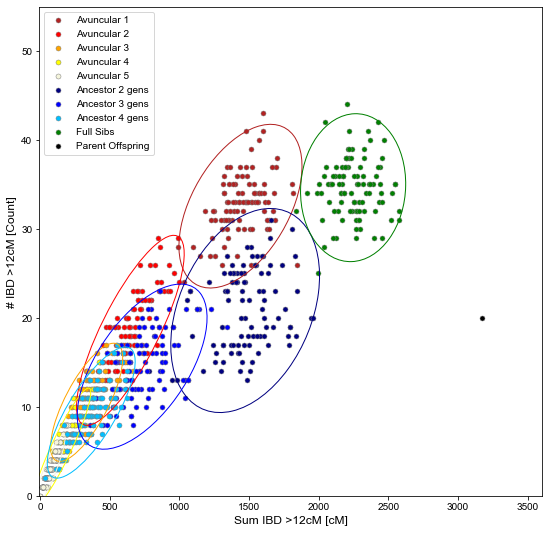

In [28]:
plt.figure(figsize=(9,9))

ax = plt.gca()

n_std=2.5
plot_scatter_ibd(ax=ax, df_ibds=df_avs[0], show=False, label="Avuncular 1", 
                 c="firebrick", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="red", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="orange", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="yellow", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="beige", s=25,  n_std=n_std)

plot_scatter_ibd(ax=ax, df_ibds=df_gps[0], show=False, label="Ancestor 2 gens", 
                 c="navy", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3 gens", 
                 c="blue", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4 gens", 
                 c="deepskyblue", s=25, n_std=n_std)

plot_scatter_ibd(ax=ax, df_ibds=df_sibs, show=False, label="Full Sibs", 
                 c="green", s=25,  n_std=n_std)
#plot_scatter_ibd(ax=ax, df_ibds=df_hsibs, show=False, label="Half Sibs", 
#                 c="gray", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_par, show=False, label="Parent Offspring", 
                 c="black", s=25,  n_std=n_std)


#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)

ax.legend(loc="upper left")
plt.savefig("", bbox_inches ='tight', pad_inches = 0, dpi=400)
plt.show()

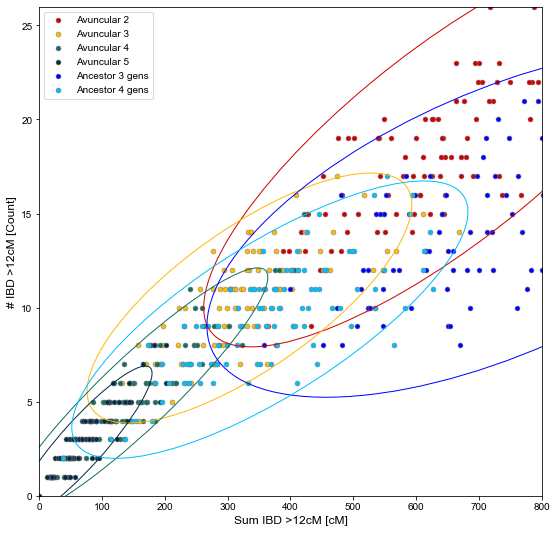

In [34]:
plt.figure(figsize=(9,9))

ax = plt.gca()

n_std=2.5
plot_scatter_ibd(ax=ax, df_ibds=df_avs[1], show=False, label="Avuncular 2", 
                 c="#d00000", s=25,  n_std=n_std)

plot_scatter_ibd(ax=ax, df_ibds=df_avs[2], show=False, label="Avuncular 3", 
                 c="#ffba08", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[3], show=False, label="Avuncular 4", 
                 c="#136f63", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_avs[4], show=False, label="Avuncular 5", 
                 c="#032b43", s=25,  n_std=n_std)

plot_scatter_ibd(ax=ax, df_ibds=df_gps[1], show=False, label="Ancestor 3 gens", 
                 c="blue", s=25,  n_std=n_std)
plot_scatter_ibd(ax=ax, df_ibds=df_gps[2], show=False, label="Ancestor 4 gens", 
                 c="deepskyblue", s=25, n_std=n_std)

#plot_scatter_ibd(ax=ax, df_ibds=df_ibds, show=False, label="V43.all data", s=30)

ax.legend(loc="upper left")
ax.set_xlim([0,800])
ax.set_ylim([0,26])
plt.show()

In [17]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms